# Algorithmes de descente en optimisation différentiable sans contrainte

Ce TP utilisera les bibliothèques `numpy`, `matplotlib.pyplot`, `time` et `scipy` qui sont importées de cette façon:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy

Dans ce TP, nous allons aborder une méthode de débruitage d'image. 

## I. Le bruit dans les images

Une image $u$ de taille $M \times N$ est une collection de pixels $MN$ organisés sous forme de tableau 2D de $M$ lignes et $N$ colonnes.

Dans ce TP, nous manipulerons des images en niveau de gris.

Le pixel de coordonnées $(i,j)$ pour $0 \leq i \leq M-1$ et $0 \leq j \leq N-1$ a une intensité $u[i,j] \in [0,1]$. 

La librairy numpy permet de charger et manipuler les images. Les images peuvent être affichés en utilisant la fonction `plt.imshow`.

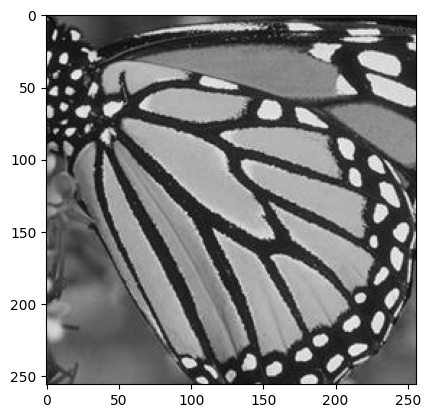

In [7]:
u = plt.imread('image.jpg') # loading image, values are integers in [0,255]
u = np.mean(np.double(u) / 255, axis = 2) # converting to grayscale and double precision in [0,1].
plt.imshow(u, cmap='gray')

De part la nature corpusculaire de la lumière et le fonctionnement des capteurs des appareils photos, les images collectées souffrent d'un bruit qui se modèlise par l'ajout d'une réalisation d'une variable aléatoire gaussienne sur chaque pixel de l'image. 
Il sera supposé que les variables aléatoires sont indépendantes et identiquement distribuées.
Ainsi, au lieu d'oberver une image $u$, on observe sa version bruitée $v$ définie par
$$
    v[i,j] = u[i,j] + n[i,j], \quad \textrm{où } n[i,j] \sim \mathcal{N}(0,\sigma^2).
$$
De manière compacte, cette équation s'écrit sous la forme
$$
    v = u + n, \quad \textrm{où } n \sim \mathcal{N}(0,\sigma^2 \textrm{Id}_{MN}).
$$

La variance $\sigma^2$ modèlise l'importance du bruit dans l'image.

La librairy `numpy` permet de générer des tableaux contenant des réalisations de varaibles aléatoire gaussienne. 

**Todo:** Utiliser la fonction `np.random.randn` pour générer l'image $v$ associée à $u$. Faire varier $\sigma$ et observer son effet.

In [15]:
sigma = 10
n = sigma * np.random.rand(u.shape[0], u.shape[1])
v = u + n

En traitement d'image, une mesure courante des performances des algorithmes de débruitage est le `psnr` qui est définie par:
$$
    \begin{split}
    \textrm{PSNR}(u,v) &= -10\log_{10}\left( \frac{1}{MN} \sum_{i,j} (u[i,j] - v[i,j])^2  \right) \\
                        &= -10\log_{10}\left( \frac{1}{MN} \| u - v \|^2  \right) \\
    \end{split}
$$
Le PSNR permet de mesurer sur une echelle logarithmique la distance entre les deux images. Plus il est élevé, plus l'image $v$ est proche de $u$.

In [16]:
def psnr(u,v):
    return -10 * np.log10(np.mean((u - v) ** 2))

**Todo:** Observer l'influence de $\sigma$ sur le PSNR(u,v).

In [17]:
print(psnr(u,v))

-15.232669798563325


## II. Le débruitage comme un problème d'optimisation

Le problème de débruitage d'une image $v$ consiste à retrouver l'image $u$ sous-jacente à partir de $v$. 
Ceci est un **problème inverse**. Il existe plusieurs méthodes de débruitage des images. Dans ce TP nous allons estimer $u$ à partir de $v$ en minimisant la fonction
$$
    f(u) = \frac{1}{2} \| u - v \|_2^2 + \lambda R(u)
$$
où 
- $\| u - v \|_2^2 = \sum_{i=1}^M  \sum_{j=1}^N (u[i,j] - v[i,j])^2$ est le terme "d'attache aux données"
- $R(u)$ est une fonction de régularisation qui est choisie pour être élevée pour les images contenant du bruit, et faible pour les images sans bruit.
- $\lambda >0$ est le paramètre de régularisation, qui permet d'opérer un compromis entre l'attache aux données et la régularisation.

### 1. Choix de la régularisation

La fonction de régularisation $R$ qui sera utilisée dans ce TP, repose sur la notion de différences finies d'une image. Pour une image $u$, il est défini par
$$
    D u[i,j] = \begin{pmatrix} D_1 u[i,j] \\ D_2 u[i,j] \end{pmatrix}
$$
où $D_1$ et $D_2$ sont définies par différences finies:
$$
    D_1 u [i,j] = \left\{ 
        \begin{split} 
            u[i+1,j] - u[i,j] & \quad \textrm{si } 0 \leq i \leq M-2 \\ 
            0 & \quad \quad \textrm{si }  i = M-1 \\ 
        \end{split} 
        \right.
$$
$$
    D_2 u [i,j] = \left\{ 
        \begin{split} 
            u[i,j+1] - u[i,j] & \quad \textrm{si } 0 \leq j \leq N-2 \\ 
            0 & \quad \quad \textrm{si }  j = N-1 \\ 
        \end{split} 
        \right.
$$

Attention, même si une image de taille $M \times N$ est stockée sous forme de tableau 2d, elle peut également être vue comme un vecteur dans $\mathbb{R}^{MN}$. Le but étant de pouvoir définir les applications linéaires agissant sur les images.  

De ce point de vue, $D$ est une application linéaire de $\mathbb{R}^{MN}$ dans $\mathbb{R}^{2MN}$.


On utilisera la notation $| Du |^2$ qui définit une image de taille $M \times N$ par $| Du |^2[i,j] = D_1u[i,j]^2 + D_2u[i,j]^2$. On dit que $|Du|^2$ est la norme de $D$.

**Todo:** Coder deux fonctions permettant de calculer $D_1 u$ et $D_2 u$.
Il est possible d'utiliser des boucles pour ce faire. Néanmoins, python étant un language interprété, cette stratégie donnera lieu à des fonctions lentes.
Une deuxième stratégie (environ 60 fois plus rapide) consiste à utiliser les mécanismes d'indexation des np.array pour implémenter ces opérations [(lien)](https://numpy.org/doc/stable/user/basics.indexing.html).

En particulier, la fonction associée à $D_1$ peut être codée de la façon suivante:

In [11]:
def d1(u):
    du=np.zeros(u.shape)
    du[:-1,:] = u[1:,:] - u[:-1,:]
    return du

Vérifier et comprendre le code de cette fonction puis coder la fonction associée à $D_2$.

In [12]:
def d2(u):
    du=np.zeros(u.shape)
    du[:,:-1] = u[:,1:] - u[:,:-1]
    return du

**Todo:** Calculer $|Du|$ et $|Dv|$ et les afficher. Commenter.

In [18]:
print(np.mean(d1(u)**2 + d2(u)**2))
print(np.mean(d1(v)**2 + d2(v)**2))

0.018345003148828976
33.14559730366828


La fonction de régularisation $R$ qui sera utilisée dans ce TP est définie par :
$$
    R(u) = r(|D u|) = \sum_{i,j} \sqrt{\epsilon^2 + |Du|[i,j]^2}
$$ 
Le code suivant calcule la valeur de $R(v)$ où $v = u + n$ et $n \sim \mathcal{N}(0,\sigma^2 \textrm{Id})$ pour différentes valeurs de $\sigma$. On observe que $\sigma \mapsto R(u + n)$ est croissante permettant ainsi de penaliser les images bruitées.

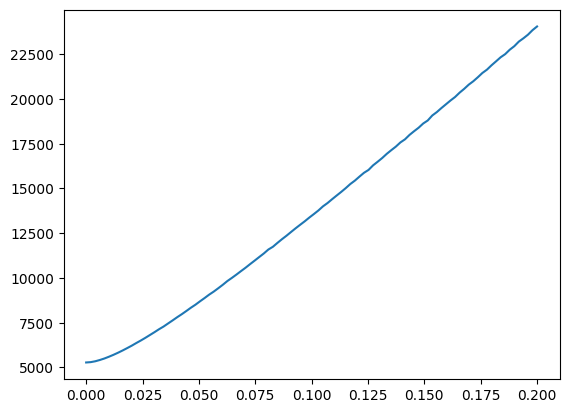

In [21]:
list_sigma = np.linspace(0,0.2,100) 
list_R = np.zeros_like(list_sigma)

nbr_test = 10
eps = 0.001 

for i, sigma in enumerate(list_sigma):
    for j in range(nbr_test):
        v = u + sigma * np.random.randn(u.shape[0], u.shape[1])
        dv = np.sqrt(d1(v)**2 + d2(v)**2) 
        list_R[i] += np.sum(np.sqrt(dv**2 + eps**2))
list_R /= nbr_test

plt.plot(list_sigma, list_R)

Cette régularisation est en réalité une version "lissée" d'une régularisation très utilisée en traitement d'image: la variation totale.
L'utilisation de la variation totale en tant que régularisation permet de favoriser les images constantes par morceaux, une propriété que le bruit ne vérifie pas.
Cependant, cette régularisation n'est pas différentiable, et sa minimisation telle quelle sort du cardre de ce cours. 

### 2. Etude de $f$ (si le temps le permet)

Le graphe de la fonction $\phi_\epsilon$ peut être tracé pour différente valeurs de $\epsilon$.

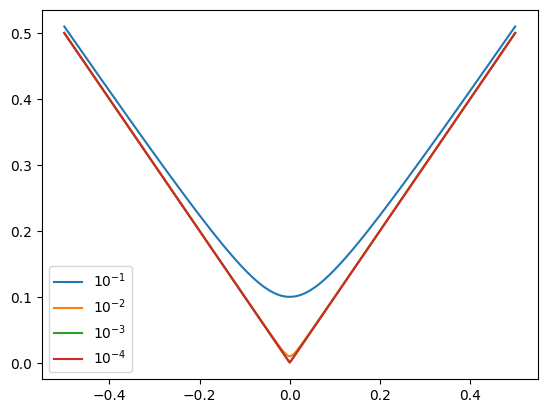

In [20]:
t = np.linspace(-0.5,0.5,1000)
plt.plot(t,np.sqrt(t**2+1e-1**2))
plt.plot(t,np.sqrt(t**2+1e-2**2))
plt.plot(t,np.sqrt(t**2+1e-3**2))
plt.plot(t,np.sqrt(t**2+1e-4**2))
plt.legend(['$10^{-1}$', '$10^{-2}$', '$10^{-3}$', '$10^{-4}$'])


**Todo:** Graphiquement, quelle est la limite de $\phi_\epsilon$ quand $\epsilon \to 0$ ?
Montrer qu'elle est convexe sur $\mathbb{R}$ et croissante sur $\mathbb{R}^+$.

**Todo:** En utilisant un exercice vu en TD, montrer que $f$ est une fonction convexe.

**Todo:** Montrer que le gradient de $R$ est 
$$
    \nabla R(u) = D^T \left( \frac{D u}{\sqrt{\epsilon^2 + |Du|^2}} \right) = D_1^T  \left( \frac{D_1 u}{{\sqrt{\epsilon^2 + |Du|^2}}}   \right) + D_2^T  \left( \frac{D_2 u}{{\sqrt{\epsilon^2 + |Du|^2}}}   \right) 
$$
où la division s'entend terme à terme. C'est à dire que 
$$
\left( \frac{D_1 u}{{\sqrt{\epsilon^2 + |Du|^2}}} \right)[i,j] = \frac{D_1 u [i,j]}{{\sqrt{\epsilon^2 + |Du|^2[i,j]}}}
$$

Déduire le gradient de $f$.

## III. Descente de gradient

Avant d'implémenter une descente de gradient pour minimiser $f$, il faut implémnter les adjoints de $D_1$ et $D_2$.

### 1. Adjoints de $D_1$ et $D_2$

Les adjoints des applications linéaires $D_i : \mathbb{R}^{MN} \to \mathbb{R}^{MN}$ peuvent être obtenus en observant que
$$
    \langle D_i u, v \rangle_{\mathbb{R}^{MN}} = \langle u, D_i^T v \rangle_{\mathbb{R}^{MN}}, \quad \forall u,v \in \mathbb{R}^{MN}.
$$
Ceci donne :
$$
    D_1^T u [i,j] = \left\{ 
        \begin{split} 
            -u[0,j] & \quad \textrm{si } 0 \leq i = 0 \\ 
            u[i-1, j] - u[i,j] & \quad \quad \textrm{si } 1 \leq i \leq M-2 \\ 
            u[M-2,j] & \quad \quad \textrm{si }  i = M-1 \\ 
        \end{split} 
        \right.
$$
$$
    D_2^T u [i,j] = \left\{ 
        \begin{split} 
            -u[i,0] & \quad \textrm{si } 0 \leq j = 0 \\ 
            u[i, j-1] - u[i,j] & \quad \quad \textrm{si } 1 \leq j \leq N-2 \\ 
            u[i,N-2] & \quad \quad \textrm{si }  j = N-1 \\ 
        \end{split} 
        \right.
$$

**Todo:** Coder deux fonctions permettant de calculer $D_1^T u$ et $D_2^T u$.

In [ ]:
def d1T(u):
### à coder

def d2T(u):
### à coder

**Test de l'exactitude de l'implémentation:** Pour rappel, une matrice $A : \R^m \to \R^n$ et son adjoint $A^T$ sont reliées par la relation
$$ 
    \langle A u, v \rangle_{\R^n} = \langle u, A^T v\rangle_{\R^m}, \quad \forall u \in \R^m, \forall v \in \R^n.
$$
Afin de vérifier que $D_1$ et $D_1^T$ sont bien adjoints il est alors possible de générer aléatoirement des vecteurs $u,v \in \R^{MN}$ et de tester que 
$$ 
    \langle D_1 u, v \rangle - \langle u, D_1^T v\rangle
$$
vaut 0. En pratique, l'arithmétique finie ne permet pas d'atteindre 0 et il seulement possible d'atteindre des valeurs proches de la pécision machine.
Le code suivant réalise les tests pour $D_1, D_2$.

In [ ]:
x = np.random.rand(u.shape[0],u.shape[1]) 
y = np.random.rand(u.shape[0],u.shape[1]) 

test1 = np.sum(d1(x)*y) - np.sum(x*d1T(y))
test2 = np.sum(d2(x)*y) - np.sum(x*d2T(y))

print('Adjoint test d1, d1T : %e, should be of the order 1e-14' % (test1)) 
print('Adjoint test d2, d2T : %e, should be of the order 1e-14' % (test2))

### 2. Constante de Lipshitz du gradient

Il est possible de montrer que la constante de Lipschitz de $\nabla R$ est $\frac{8}{\epsilon}$.

**Todo:** En déduire un majorant $L$ de la constante de Lipschitz de $\nabla f$ et interpréter.

### 3. Descente de gradient

Implémenter l'algorithme de descente de gradient à pas fixe

$$ x_{k+1} = x_k - s \nabla f(x_k) $$

* Choisir $x_0 = v$.
* Le critère d'arrêt sera sur la norme du gradient:
$$
    \frac{\| \nabla f(x_k) \|}{\| \nabla f(v) \|}  < \eta
$$
et un nombre d'itérations maximal de 20000.
Calculer à chaque itération la valeur de $f(x_k)$ et les stocker dans une liste.
* Calculer le temps nécessaire pour la convergence de l'algorithme avec la fonction `time.time()`

In [ ]:
sigma = 0.05
v = u + sigma * np.random.randn(u.shape[0], u.shape[1])

nit = 20000
epsilon = 0.001
l = 0.06
x = v
L = 1 + l* 8 / epsilon
step = 2/L

eta = 1e-2

listcf = [] 

start = time.time()

### descente à coder

end = time.time()

**Todo:** Tester la méhode pour un bruit de niveau $\sigma = 0.05$, choisir $\epsilon = 0.001$,  $\eta = 10^{-2}$ et $\lambda = 0.06$. 

Le code suivant affiche le psnr de la solution, la fonction cout en echelle semilogy, le nombre d'itérations necessaire, le temps de calcul et le temps de calul par itération.

In [ ]:
listcf_grad = np.array(listcf)
plt.figure()
plt.semilogy(listcf_grad)

plt.figure()
plt.imshow(x, cmap='gray')
print('Psnr denoised: %.2fdB' % (psnr(u, x)))
print('Number of iterations: %d' % (i))
print('Elapsed time: %.2f s' % (end - start))
print('Time spent per iteration: %.2fms' % (1000*(end - start)/i))

**Todo:** Changer les valeurs de $\sigma$, $\lambda$ et $\epsilon$ pour oberver leurs effets.

## III. Méthode de quasi-Newton

Dans cette partie, nous allons implémenter une méthode de quasi-Newton pour minimiser $f$. Les itérations sont de la forme :
$$ x_{k+1} = x_k - H_k^{-1} \nabla f(x_k) $$
où les $H_k$ sont des approximations des matrices hessiennes $H[f](x_k)$.
Dans ce TP nous allons utiliser les matrices :
$$
    H_k = \textrm{Id} + \lambda D^* W_k D, \quad \text{avec } W_k = \textrm{diag}\left(\frac{1}{\sqrt{\epsilon^2 + |Du|^2}}\right)
$$
c'est à dire qu'un produit matrice-vecteur avec le vecteur $d$ donne
$$
    H_k d = d + \lambda \left( D_1^T \left( \frac{D_1 d}{\sqrt{\epsilon^2 + |Du|^2}} \right) + D_2^T \left( \frac{D_2 d}{\sqrt{\epsilon^2 + |Du|^2}} \right) \right)
$$
où la division s'entend terme à terme.

La difficulté de la mise en oeuvre d'une méthode de quasi-Newton est la résolution du système linéaire. Pour une image de taille $256 \times 256$ stocker la matrice $H_k$ en mémoire coûte 32GB et inverser une telle matrice exactement est impossible. Heuresement, la méthode de quasi-Newton nécessite seuelement une bonne approximation de la solution du système linéaire pour foncitonner. Une telle approximation peut être calculée en utilisant une méthode itérative (gradient conjugué) qui nécessite uniquement des fonctions capables de calculer les produits matrice-vecteur $H_k d$ pour tout $d$. 

### 1. Produit matrice-vecteur avec $H_k$

**Todo:** Implémenter une fonction `mvp_H` implémentant le produit matrice vecteur $H d$ où $H$ est l'approximation de $H[f](u)$ définie précédemment. Cette fonction prend en entrée :
- `normGrad` l'image de taille $M \times N$ contenant $\sqrt{\epsilon^2 + |Du|^2}$
- `d` une image de taille $M \times N$
- `l` la valeur de $\lambda$, le paramètre de régularisation
- `epsilon` la valeur de $\epsilon$

In [ ]:
### à coder

### 2. Résolution du système linéaire

Le système linéaire $H d = v$ peut maintenant être résolu en utilisant une méthode de gradient conjugué (non-abordée dans ce cours).
Cet algorithme est implémenté dans la librairy `scipy`. Vous pouvez utiliser la fonction `newton_direction` suivante afin d'obtenir la direction $d$ définie par $H d = b$.
Les arguments de cette fonction sont:
- `normGrad` l'image de taille $M \times N$ contenant $\sqrt{\epsilon^2 + |Du|^2}$ où $u$
- `b` une image de taille $M \times N$
- `l` la valeur de $\lambda$, le paramètre de régularisation
- `epsilon` la valeur de $\epsilon$
- `rtol` la tolérance de résolution du système linéaire. `rtol = 1e-1` donne de bons résultats dans ce cas.

In [ ]:
def newton_direction(normGrad,l, b, epsilon, rtol=1e-2):
    mvp = lambda h : mvh_H(normGrad, h.reshape(normGrad.shape[0],normGrad.shape[1]), l, epsilon).reshape(-1)
    H = scipy.sparse.linalg.LinearOperator(shape = (normGrad.shape[0]*normGrad.shape[1],normGrad.shape[0]*normGrad.shape[1]), matvec = mvp, rmatvec = mvp)
    d,info = scipy.sparse.linalg.cg(H,b = b.reshape(-1), x0 = b.reshape(-1), rtol = 1e-1)
    return d

### 3. Implémentation de la descente

**Todo:** Implémenter la descente de quasi-Newton.
Comme pour la descente de gradient: 
* Choisir $x_0 = v$.
* Le critère d'arrêt sera sur la norme du gradient:
$$
    \frac{\| \nabla f(x_k) \|}{\| \nabla f(v) \|}  < \eta
$$
et un nombre d'itérations maximal de 100.
* Calculer à chaque itération la valeur de $f(x_k)$ et les stocker dans une liste.
* Calculer le temps nécessaire pour la convergence de l'algoithme avec la fonction `time.time()`

In [ ]:
nit = 100
epsilon = 0.001
l = 0.06
x = v

listcf = [] 
list_err = []

### descente à coder

**Todo:** Tester la méhode pour un bruit de niveau $\sigma = 0.05$, choisir $\epsilon = 0.001$,  $\eta = 10^{-2}$ et $\lambda = 0.06$. 

Le code suivannt affiche le psnr la solution, la fonction cout en echelle semilogy, le nombre d'itérations necessaire, le temps de calcul et le temps de calul par itération.

In [ ]:
listcf_newton = np.array(listcf)
plt.figure()
plt.semilogy(listcf)

plt.figure()
plt.imshow(x, cmap='gray')
print('Psnr denoised: %.2fdB' % (psnr(u, x)))
print('Number of iterations: %d' % (i))
print('Elapsed time: %.2f s' % (end - start))
print('Time spent per iteration: %.2fms' % (1000*(end - start)/i))

**Todo:** Changer les valeurs de $\sigma$, $\lambda$ et $\epsilon$ pour oberver leurs effets.

### 4. Comparaison avec la descente de gradient

**Todo** : comparer les performances avec la descente de gradient. On pourra en particulier regarder les performances des deux algorithmes pour $\epsilon = 10^{-2},10^{-3},10^{-4}$